In [3]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import re

In [4]:
sys.path.insert(0, '/home/llr/cms/wind/cmssw/CMSSW_9_4_2/src/ZZAnalysis/AnalysisStep/test/Python/')

In [5]:
from trainlib.ConfigFileHandler import ConfigFileHandler
from trainlib.ModelCollectionConfigFileHandler import ModelCollectionConfigFileHandler
from trainlib.ConfigFileUtils import ConfigFileUtils

Welcome to JupyROOT 6.10/09


Using TensorFlow backend.


In [6]:
campaign_workspace = "/data_CMS/cms/wind/"

In [7]:
def strip_differential(raw):
    raw = raw.replace("_2j", "")
    raw = raw.replace("_1j", "")
    raw = raw.replace("_0j", "")
    return raw

In [8]:
def make_comparison_plot(campaign_workspace, campaign_names, campaign_labels, average = False, outdir = None):
    df_loss = pd.DataFrame()
    df_H1_length = pd.DataFrame()
    df_H0_length = pd.DataFrame()
    
    for campaign_name in campaign_names:
        campaign_dir = os.path.join(campaign_workspace, campaign_name)
        
        values_loss = {}
        values_H1_length = {}
        values_H0_length = {}

        values_loss["campaign"] = campaign_name
        values_H1_length["campaign"] = campaign_name
        values_H0_length["campaign"] = campaign_name

        # read all the files
        for root, dirs, files in os.walk(campaign_dir):
            for curfile in files:
                if curfile.endswith("model_benchmark.txt"):
                    config_file = os.path.join(root, "model_benchmark.txt")

                    confhandler = ConfigFileHandler()
                    confhandler.load_configuration(config_file)

                    # now look at all of the sections 
                    models = confhandler.get_sections()
                    for model in models:
                        values_loss[model] = float(confhandler.get_field(model, 'val_loss'))
                        values_H1_length[model] = int(confhandler.get_field(model, 'H1_val_length'))
                        values_H0_length[model] = int(confhandler.get_field(model, 'H0_val_length'))

        # starting from this fully differential information, now go ahead and average over those differential ones
        values_loss_avg = {}
        values_H1_length_avg = {}
        values_H0_length_avg = {}

        values_loss_avg["campaign"] = campaign_name
        values_H1_length_avg["campaign"] = campaign_name
        values_H0_length_avg["campaign"] = campaign_name
        
        models = [model for model in values_loss.keys() if model is not "campaign"]
        for model in models:
            model_avg = strip_differential(model)

            if not model_avg in values_loss_avg:
                values_loss_avg[model_avg] = 0
                values_H1_length_avg[model_avg] = 0
                values_H0_length_avg[model_avg] = 0

            values_loss_avg[model_avg] += values_loss[model] * (values_H1_length[model] + values_H0_length[model])
            values_H1_length_avg[model_avg] += values_H1_length[model]
            values_H0_length_avg[model_avg] += values_H0_length[model]

        print values_loss_avg
        print values_H1_length_avg
        print values_H0_length_avg

        # now need again divide by their training dataset lengths to get the mean error on the averaged models
        for model_avg in values_loss_avg.keys():
            if not "campaign" in model_avg:
                values_loss_avg[model_avg] /= (values_H1_length_avg[model_avg] + values_H0_length_avg[model_avg])

        if average:
            df_loss = df_loss.append(pd.DataFrame(values_loss_avg, index = [len(df_loss)]))
            df_H1_length = df_H1_length.append(pd.DataFrame(values_H1_length_avg, index = [len(df_H1_length)]))
            df_H0_length = df_H0_length.append(pd.DataFrame(values_H0_length_avg, index = [len(df_H0_length)]))
        else:
            df_loss = df_loss.append(pd.DataFrame(values_loss, index = [len(df_loss)]))
            df_H1_length = df_H1_length.append(pd.DataFrame(values_H1_length, index = [len(df_H1_length)]))
            df_H0_length = df_H0_length.append(pd.DataFrame(values_H0_length, index = [len(df_H0_length)]))

    fig = plt.figure(figsize = (15, 5))
    
    # save the plot data, if this is demanded
    if outdir is not None:
        if not os.path.exists(outdir):
            os.makedirs(outdir)
            
        df_loss.to_csv(os.path.join(outdir, "loss.csv"))
        df_H1_length.to_csv(os.path.join(outdir, "H1_length.csv"))
        df_H0_length.to_csv(os.path.join(outdir, "H0_length.csv"))
    
    if len(df_loss) > 0:
        models = [col for col in df_loss.columns if "campaign" not in col]
        
        df_loss.fillna(10.0)
        # condense all the different loss values into one global loss estimate (if such a thing can reasonably be done)
        # each loss value is already an average over its specific training dataset -> compute the global average by first undoing all the local ones
        loss_averages = df_loss[models].as_matrix()
        dataset_lengths = df_H1_length[models].as_matrix() + df_H0_length[models].as_matrix()
        
        global_losses = np.sum(np.multiply(loss_averages, dataset_lengths), axis = 1)
        total_lengths = np.sum(dataset_lengths, axis = 1)
        global_losses = np.divide(global_losses, total_lengths)

        loss_data = df_loss[models].as_matrix()
        loss_data = np.divide(loss_data, loss_data[0])
        loss_data_columns = np.concatenate([[''], df_loss[models].columns])
        loss_data_rows = np.concatenate([[''], df_loss['campaign'].as_matrix()])

        ax = fig.add_subplot(111)
        cax = ax.matshow(loss_data, cmap = 'RdYlGn_r', vmin = 0.9, vmax = 1.1, aspect = 3.0)
        fig.colorbar(cax, pad = 0.1)
        #ax.set_yticklabels(loss_data_rows)
        ax.set_yticklabels([''] + campaign_labels)
        ax.set_xticklabels(loss_data_columns, rotation = 'vertical')
        
        ax.text(len(loss_data_columns), -1.0, "global", va = "center", ha = "center", rotation = "vertical")

        for y, gloss in enumerate(global_losses):
            print gloss
            ax.text(len(loss_data_columns), y, "{:4.4f}".format(gloss), va = 'center', ha = 'center', rotation = 'horizontal')

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
    return fig

In [23]:
%%capture
plot_17 = make_comparison_plot(campaign_workspace, ["180426_combined_99",
                                                    "180426_exclusive_99",
                                                    "180425_inclusive_models"],
                                                   ["combined", "exclusive", "inclusive"], True)

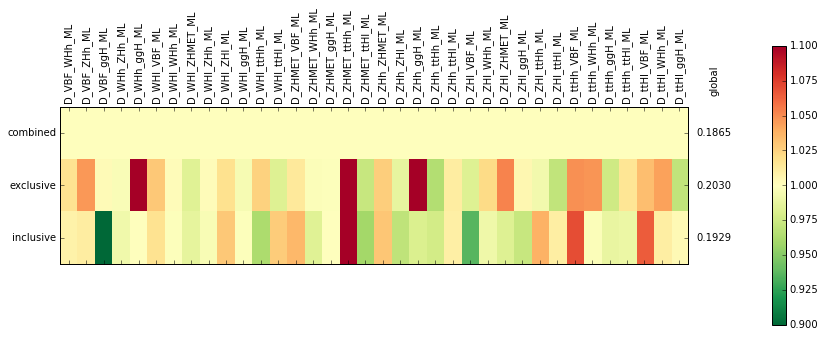

In [24]:
plt.show()

In [19]:
%%capture
plot_17 = make_comparison_plot(campaign_workspace, ["180429_combined_fullmassrange",
                                                   "180427_combined_optimized_inputs"],
                                                   ["combined_fullmassrange", "combined_optimized"], True)

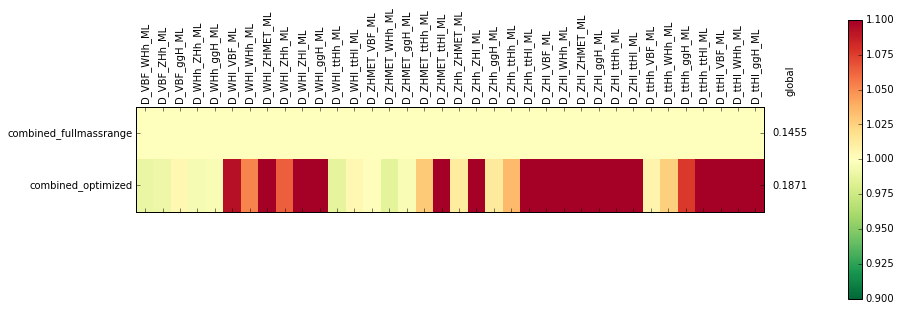

In [20]:
plt.show()

In [17]:
%%capture
sweep_plot = make_comparison_plot(campaign_workspace, ["180429_hyperparameter_sweep/number_neurons_16.0number_layers_0.0/",
                                                       "180429_hyperparameter_sweep/number_neurons_16.0number_layers_1.0/",
                                                       "180429_hyperparameter_sweep/number_neurons_16.0number_layers_3.0/",
                                                       "180427_hyperparameter_sweep/number_neurons_32.0number_layers_1.0/",
                                                       "180427_hyperparameter_sweep/number_neurons_32.0number_layers_3.0/",
                                                       "180427_hyperparameter_sweep/number_neurons_64.0number_layers_1.0/",
                                                       "180427_hyperparameter_sweep/number_neurons_64.0number_layers_3.0/",
                                                       "180427_hyperparameter_sweep/number_neurons_96.0number_layers_1.0/",
                                                       "180427_hyperparameter_sweep/number_neurons_96.0number_layers_3.0/",
                                                       "180428_hyperparameter_sweep/number_neurons_32.0number_layers_0.0/",
                                                       "180428_hyperparameter_sweep/number_neurons_64.0number_layers_0.0/",
                                                       "180428_hyperparameter_sweep/number_neurons_96.0number_layers_0.0/",
                                                        ],
                                                      ["16 hidden neurons, 1 hidden layer",
                                                      "16 hidden neurons, 2 hidden layers",
                                                      "16 hidden neurons, 3 hidden layers",
                                                      "32 hidden neurons, 2 hidden layers",
                                                      "32 hidden neurons, 4 hidden layers",
                                                      "64 hidden neurons, 2 hidden layers",
                                                      "64 hidden neurons, 4 hidden layers",
                                                      "96 hidden neurons, 2 hidden layers",
                                                      "96 hidden neurons, 4 hidden layers",
                                                      "32 hidden neurons, 1 hidden layer",
                                                      "64 hidden neurons, 1 hidden layer",
                                                      "96 hidden neurons, 1 hidden layer"], True,
                                                     "/data_CMS/cms/wind/HyperparameterPlots/")

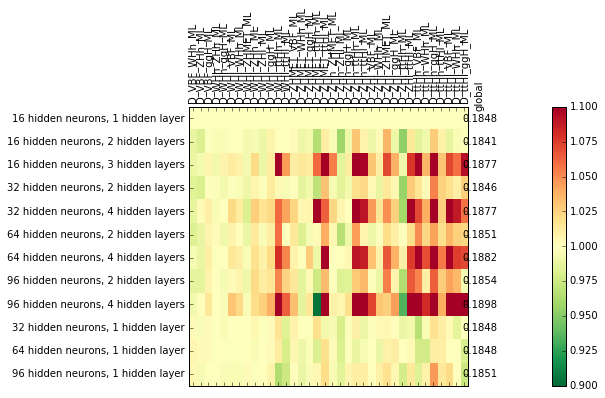

In [18]:
plt.show()